# Software development patterns through git data mining


In [2]:
import sys, os, getpass, warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.join(os.getcwd(), "..", "src"))
from patterns.visualizer import Visualizer

Create a `Visualizer` object for a project, e.g., for Spack, `vis = Visualizer('spack')`. This brings in data from database and annotate it with *locc*, *locc+*, *locc-*, *change-size-cos* = *1-similarity* (**expensive call**). The data is cached locally after it's fetched from the database and subsequently loaded from disk, unless you specify the `cache=False` parameter, e.g., `vis.get_data(cache=False)`. Available projects include `'lammps', 'spack', 'petsc', 'Nek5000', 'nwchem', 'E3SM', 'qmcpack', 'qdpxx', 'LATTE', 'namd', 'enzo-dev'` (the full list can be obtained with by calling the `Visualizer()` constructor without arguments.

The `get_data` method automatically removes changes associated with non-code files. The determination of what is code is made by including common suffixes, as well as checking manually a sampling of ECP projects for the suffixes used for things that can be labeled as code (vs. input simulation data, documentation, or generated files), for a list of suffixes, refer to the `Patterns.code_suffixes` list in [patterns.py](https://github.com/HPCL/ideas-uo/blob/master/src/patterns/patterns.py). This makes the analysis of decades of project data feasible. You can disable this if desired, by passing the `code_only=False` parameter to `get_data`. You can also explicitly remove non-code rows with `vis.remove_noncode()`. Optionally, you can remove files that are likely copies of external code (path contains `extern` or `contrib`) with `vis.remove_external()`.

In [3]:
vis = Visualizer(project_name='spack')
vis.get_data()

Database password:········
INFO: Loading spack data from database. This can take a while...
INFO: Loaded spack data from the database (exclude_forks=False, forks_only=False)
INFO: Cleaning up data and computing averages...
INFO: Done computing averages. 115398 file changes (code only)


By default, the names of projects and developers are not shown in the figures. If you wish to include project names, set `vis.hide_names` to `False`.

In [4]:
vis.hide_names = False

Let's start with some global views -- this plot shows the entire project's git history (including imports from other RCS). The three different metrics shown represent different ways of quantifying the magnitude of the change based on the differences produced by `git log`. The `locc+` and `locc-` lines are lines added and removed, respectively. The `change-size-cos` is one of many text difference metrics, which computes the "distance" between the old and new code snippets in each commit. We discuss distance metrics in more detail later.

              locc+         locc-  change-size-cos
count      39.00000     39.000000        39.000000
mean    15102.74359   3375.179487       865.236598
std     18599.61647   7168.825386       729.598737
min         0.00000      0.000000         0.000000
max    113490.00000  45371.000000      3054.048023


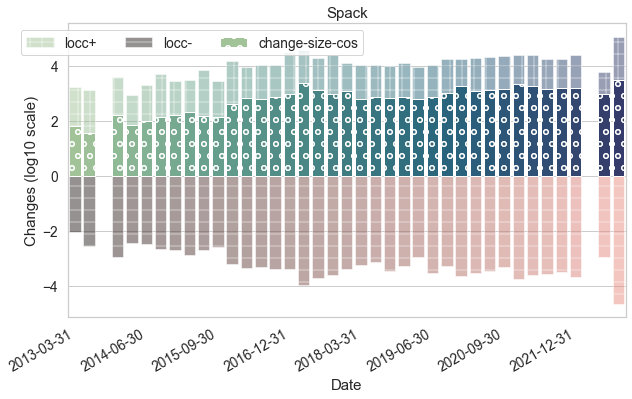

In [5]:
df = vis.plot_overall_project_locc(log=True)

to focus on a given year and/or month, set *year* and *month* fields

In [6]:
vis.set_year(2020)
vis.set_month(10)

to plot for a given year, provide *time_range='year'*

             locc+        locc-  change-size-cos
count    12.000000    12.000000        12.000000
mean   7235.083333  1169.416667       510.883490
std    1299.134849   568.045686       152.857587
min    5475.000000   603.000000       344.868857
max    9607.000000  2485.000000       920.286300


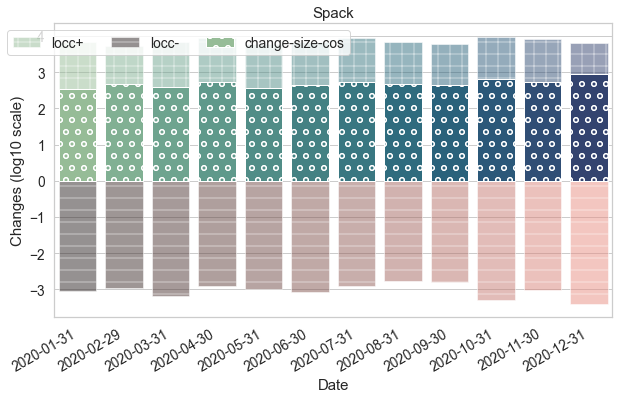

In [7]:
df = vis.plot_overall_project_locc(time_range='year',log=True)

similarly to plot for a given month, set *time_range='month'*

             locc+       locc-  change-size-cos
count    31.000000   31.000000        31.000000
mean    309.903226   64.354839        20.481982
std     305.996444  120.838335        17.696508
min      10.000000    0.000000         1.117727
max    1429.000000  498.000000        78.658128


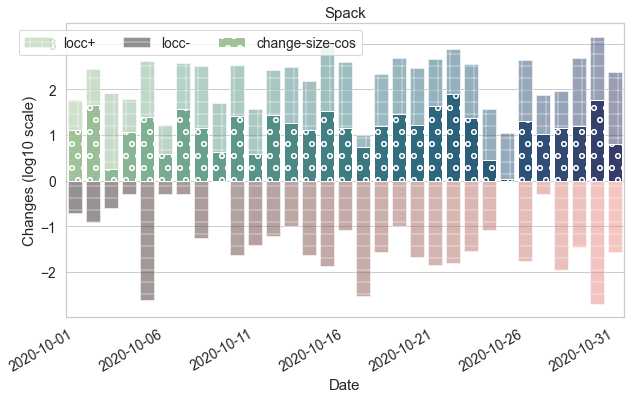

In [8]:
df = vis.plot_overall_project_locc(time_range='month',log=True)

### Finding trends with averages
We can plot the annual averages timeline for the entire project's history (by default showing LOCC and cos distance) with `plot_total_avg`. Several moving average plots are available, with different aggregation granularities (year, month) and different sliding window sizes.

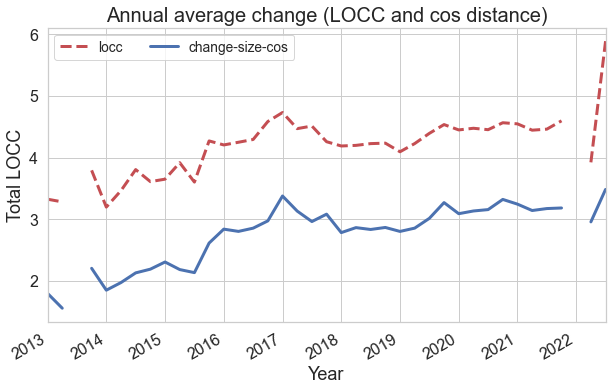

In [9]:
vis.plot_total_avg(log=True)

We can also compute different moving averages, indicating the aggregation frequency with the `freq` paramater. The default is `quarter`.

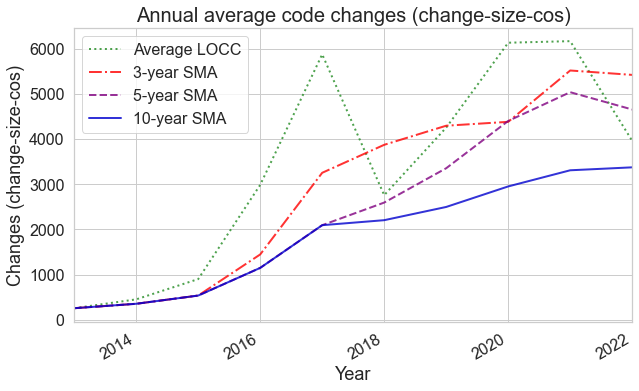

In [10]:
vis.plot_total_moving_avgs(freq='year')

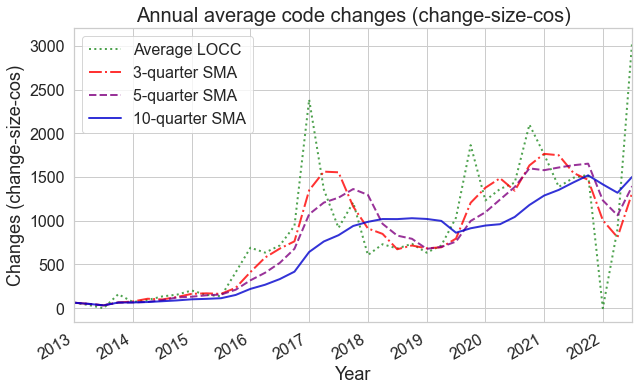

In [11]:
vis.plot_total_moving_avgs()

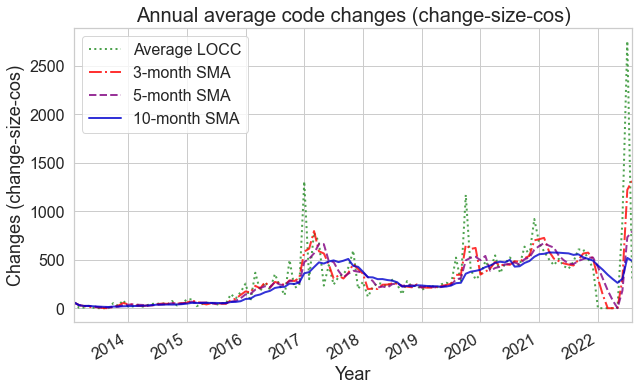

In [12]:
vis.plot_total_moving_avgs(freq='month')

## More timelines
This reflects changed lines of code as reported in git commit diffs. We have two functions that generate timeline plots of a change metric: `plot_proj_change_line` and `plot_proj_change_bubble`. By default, they show the entire range of selected dates and use the cos distance metric. You can specify a different metric with the `locc_metric` argument, e.g., `vis.plot_proj_change_line(locc_metric='locc')`

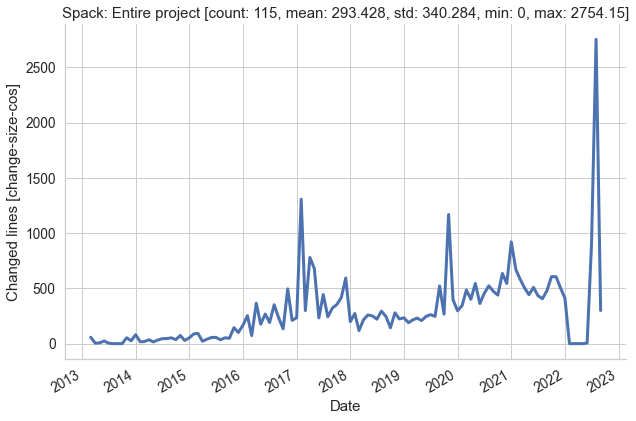

In [13]:
df = vis.plot_proj_change_line()

And looking at both line counts (LOCC) and the distance based `change-size-cos` at the same time. If not specified, the time_range argument defaults None, which indicates the entire time period of the dataset.

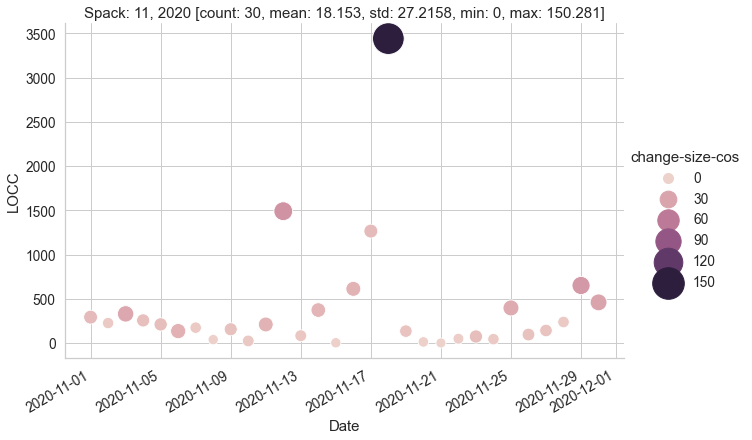

In [14]:
vis.set_month(11)
df = vis.plot_proj_change_bubble(time_range="month")

We can choose to zoom into a specific year, recall that previously we did `vis.set_year(2020)`.

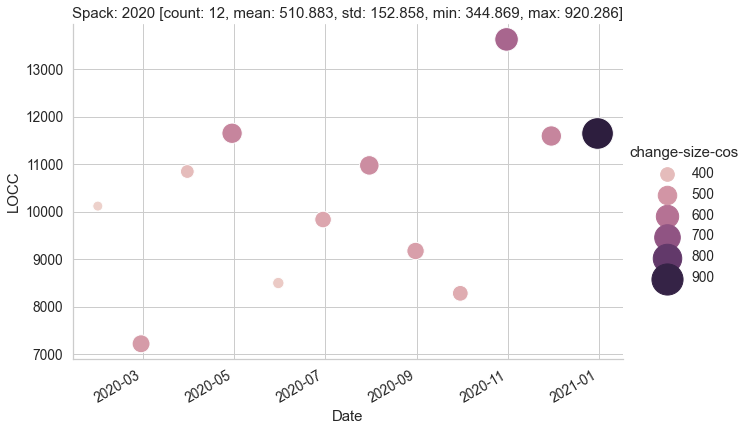

In [15]:
df = vis.plot_proj_change_bubble(time_range='year')

Or a specific year range.

              locc+         locc-  change-size-cos
count      39.00000     39.000000        39.000000
mean    15102.74359   3375.179487       865.236598
std     18599.61647   7168.825386       729.598737
min         0.00000      0.000000         0.000000
max    113490.00000  45371.000000      3054.048023


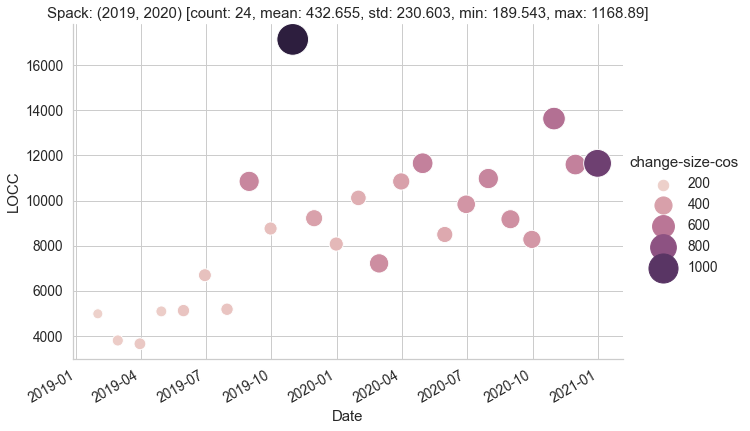

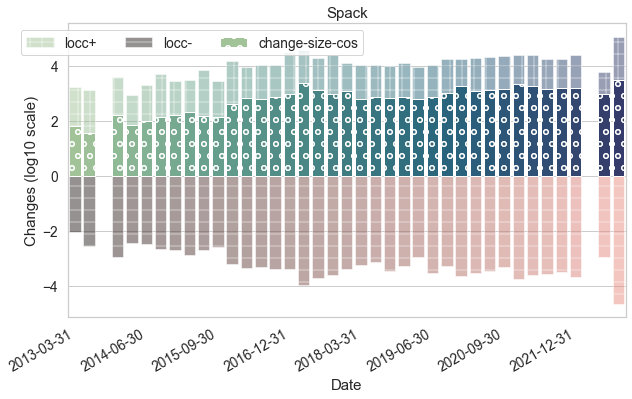

In [16]:
vis.select_year_range(2019,2020)
vis.plot_proj_change_bubble(time_range='year-year')
df = vis.plot_overall_project_locc(time_range='year-year',log=True)

We can also zoom into a single month; recall we previously did:
```
vis.set_year(2019)
vis.set_month(10)
```

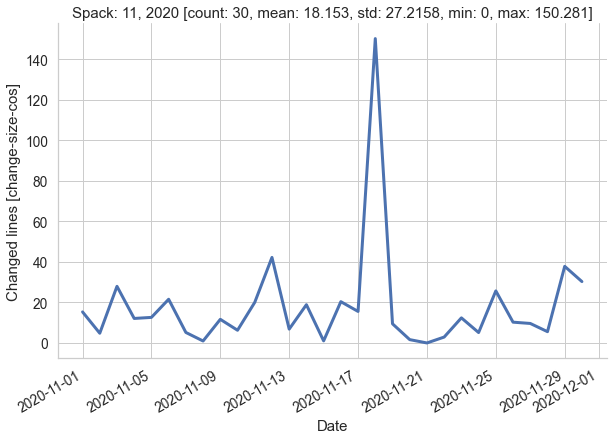

In [17]:
_ = vis.plot_proj_change_line(time_range='month')

Or a month range

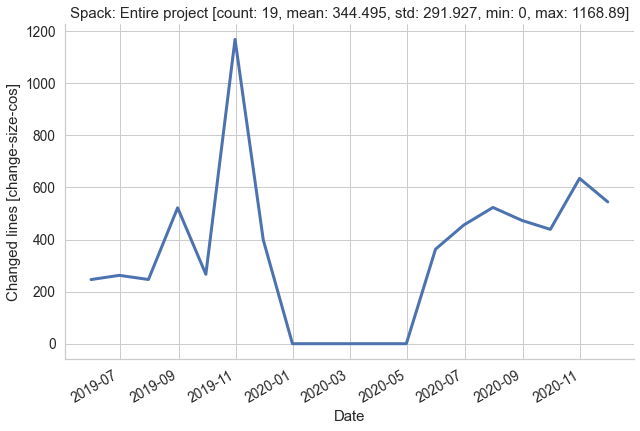

In [18]:
vis.select_month_range(5,11)
df = vis.plot_proj_change_line(time_range='month-month')

## Using a text distance metric to adjust the size of the changes

We use the python [textdistance](https://github.com/life4/textdistance) module. The following algorithms have been integrated with the visualizer.
```
'cos', 'hamming', 'damerau_levenshtein', 'jaccard', 'jaro', 'jaro_winkler', 'bag', 'editex'
```
Any of the above plots can be made with any line counting metric, typically specified through the `locc_metric` argument.

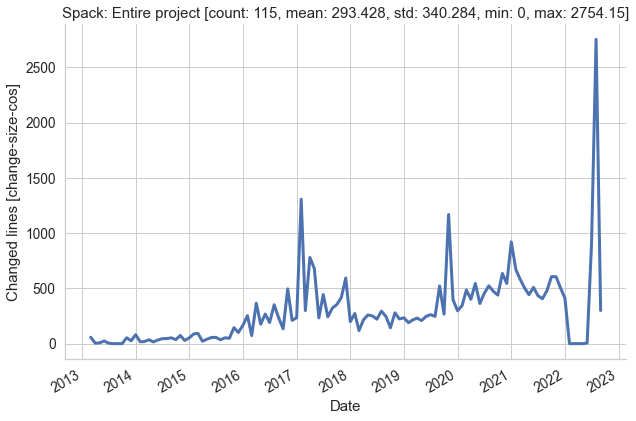

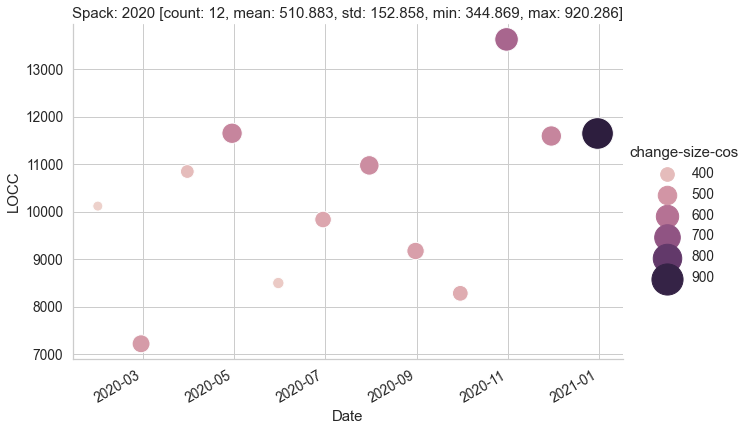

In [19]:
vis.set_diff_alg('jaccard')
df = vis.plot_proj_change_line()
_ = vis.plot_proj_change_bubble()

## More patterns
Here we look at a combination of the the high-churn and domain champion patterns. Basically we are focusing on the files that have the most changes and restricting the developers by those with the biggest contributions. One tricky issue that makes this nontrivial is that contributors use different names for their contributions. We have implemented a fuzzy name matching scheme of author names using the python `fuzzywuzzy` package to consolidate single-author contributions as much as possible.

INFO: Creating developer matrix...
INFO: Analyzing author names, this can take a few minutes...


unique_author,Todd Gamblin,Massimiliano Culpo,Adam J. Stewart,Peter Josef Scheibel,Glenn P Johnson,Greg Becker,Gregory Becker,Tamara Dahlgren,Scott Wittenburg,Patrick Gartung
filepath,,,,,,,,,,
lib/spack/spack/binary_distribution.py,2228,210,9,17,0,95,6,49,1644,1154
lib/spack/spack/environment.py,2193,390,148,730,0,767,1499,53,12,0
lib/spack/spack/package.py,4072,821,791,240,0,689,723,1210,2,17
lib/spack/spack/solver/asp.py,8066,1566,11,23,0,237,40,0,20,0
lib/spack/spack/spec.py,10014,1669,111,352,0,435,1085,7,255,0


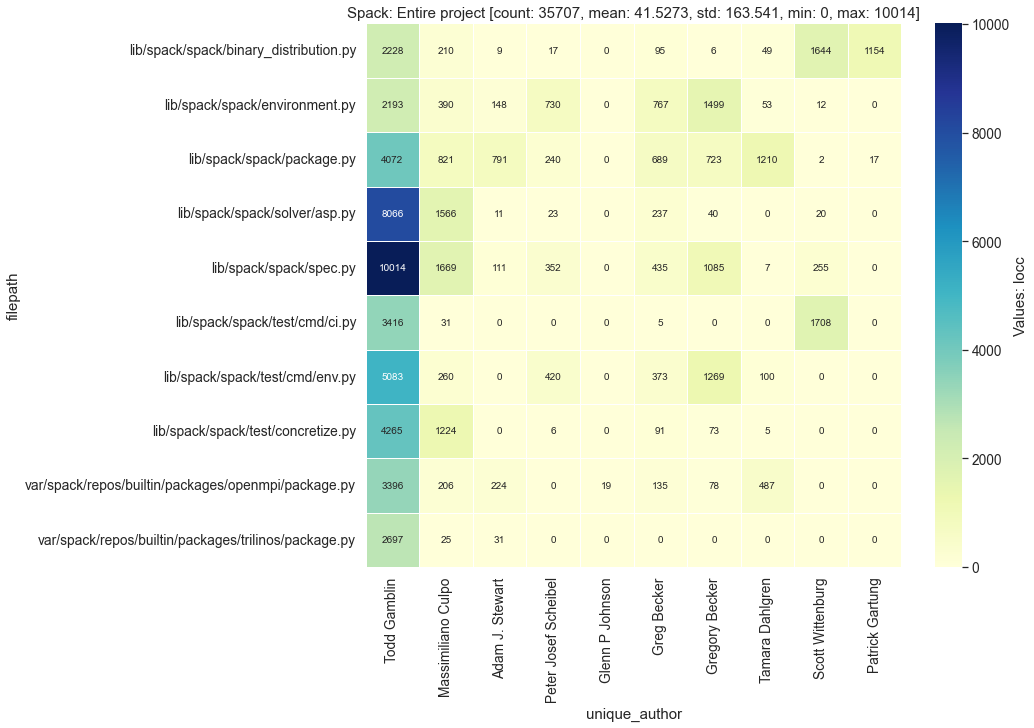

In [20]:
N = 10
vis.reset()
#vis.set_unique_authors()  # force author recomputation, this is expensive, so the result will be cached
vis.set_max_ylabel_length(30)
top_N = vis.plot_top_N_heatmap(N, locc_metric='locc')
top_N.head()

INFO: Creating developer matrix...


unique_author,Todd Gamblin,Adam J. Stewart,Massimiliano Culpo,Glenn P Johnson,Gregory Becker,Greg Becker,Michael Kuhn,Harmen Stoppels,Denis Davydov,Ben Boeckel
filepath,,,,,,,,,,
lib/spack/spack/build_environment.py,30.061115,6.775114,10.899779,1.0,24.768965,4.405353,3.000000,3.457178,1.868951,2.241725
lib/spack/spack/package.py,85.940338,14.539635,24.524569,0.0,31.806388,12.616549,4.000000,2.854572,2.379161,1.111201
lib/spack/spack/solver/asp.py,69.093913,0.697993,43.181463,0.0,3.658825,3.387894,0.000000,1.429339,0.000000,0.000000
lib/spack/spack/spec.py,77.170190,1.945207,32.806323,0.0,41.900123,10.072439,1.071915,0.574645,1.000000,1.143007
lib/spack/spack/test/concretize.py,16.854934,0.000000,70.752246,0.0,5.314557,5.902432,0.000000,0.156535,1.000000,0.117982


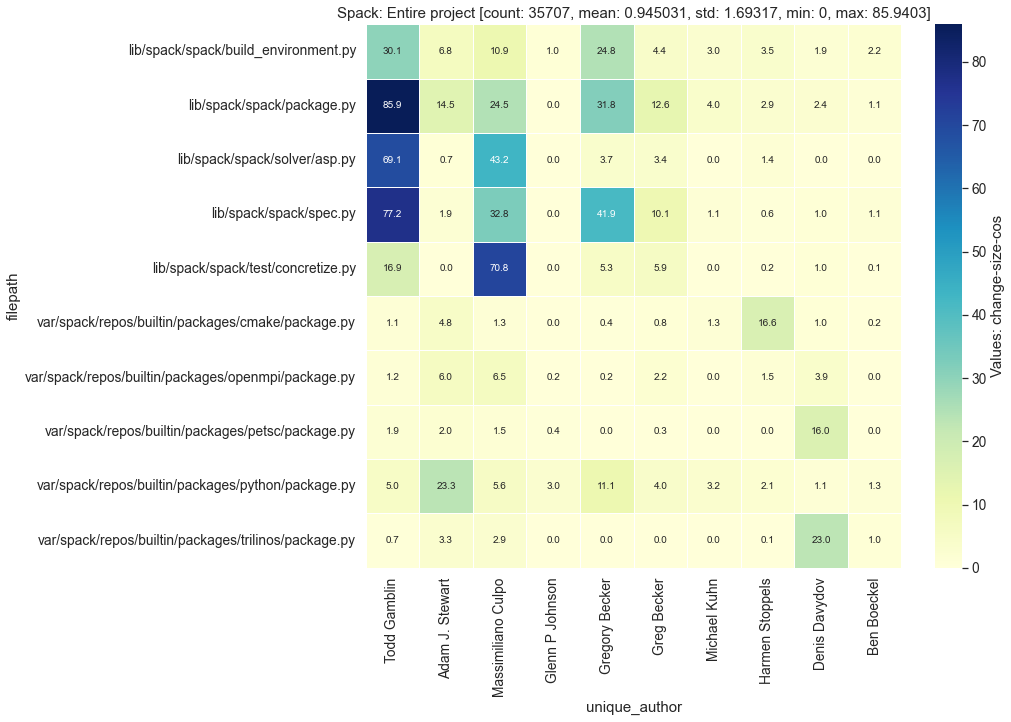

In [21]:
top_N_cos = vis.plot_top_N_heatmap(N, locc_metric='change-size-cos')
top_N_cos.head()

INFO: Creating developer matrix...


unique_author,Adam J. Stewart,Massimiliano Culpo,Greg Becker,Tamara Dahlgren,Gregory Becker,Todd Gamblin,Michael Kuhn,Andrew W Elble,Axel Huebl,Scott Wittenburg
filepath,,,,,,,,,,
lib/spack/spack/installer.py,1.000000,0.261997,5.418088,5.910873,0.076734,1.122051,2.536231,0.000000,0.590962,3.817793
lib/spack/spack/package.py,0.422784,2.433366,6.548974,6.107620,18.482208,0.878985,3.000000,0.000000,1.812477,0.188965
lib/spack/spack/solver/asp.py,0.000000,27.628147,0.000000,0.000000,0.614358,27.030197,0.000000,2.645331,0.000000,1.282725
lib/spack/spack/spec.py,0.000000,8.482664,4.261516,0.898463,4.621275,4.948336,0.000000,2.000000,0.000000,3.331127
lib/spack/spack/test/cmd/env.py,0.000000,4.429258,5.646928,1.985124,1.000000,2.434433,0.000000,0.000000,0.000000,0.000000


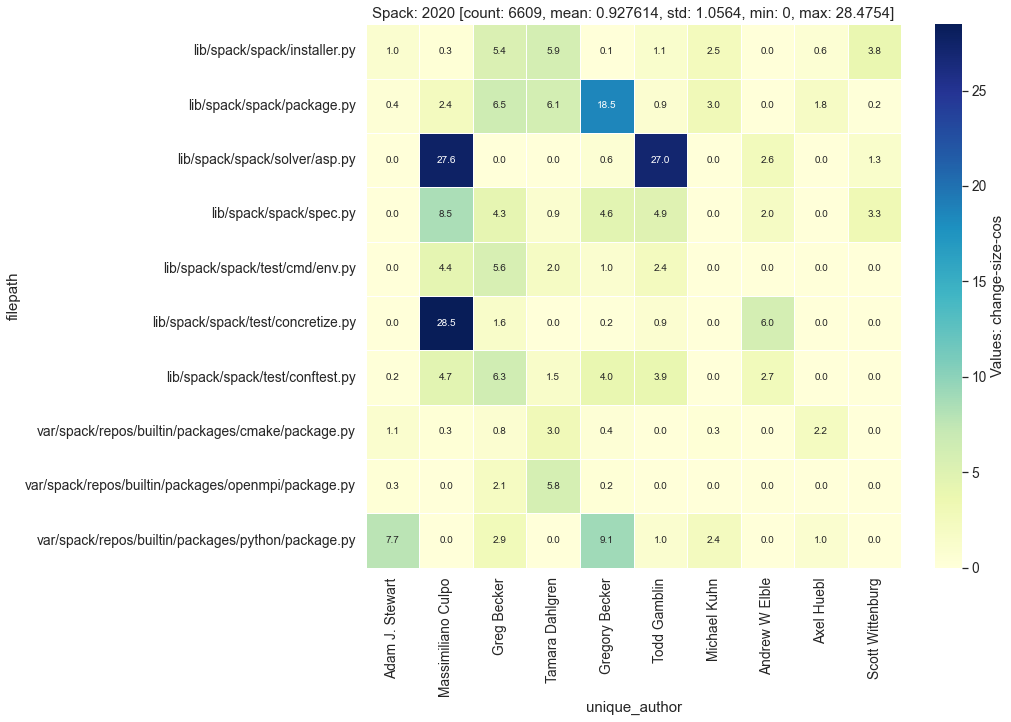

In [22]:
vis.set_year(2020)
top_N_cos = vis.plot_top_N_heatmap(N, time_range='year', locc_metric='change-size-cos')
top_N_cos.head()

We can also easily see the exact differences between different ways of measuring change. This is not something that we normally compute frequently, hence there isn't a special plot function.

In [23]:
file_dev_locc, _ = vis.make_file_developer_df(locc_metric='locc')
file_dev_diff, _ = vis.make_file_developer_df(locc_metric='change-size-cos')

INFO: Creating developer matrix...
INFO: Creating developer matrix...


Total number of developers: 1014
INFO: Creating developer matrix...


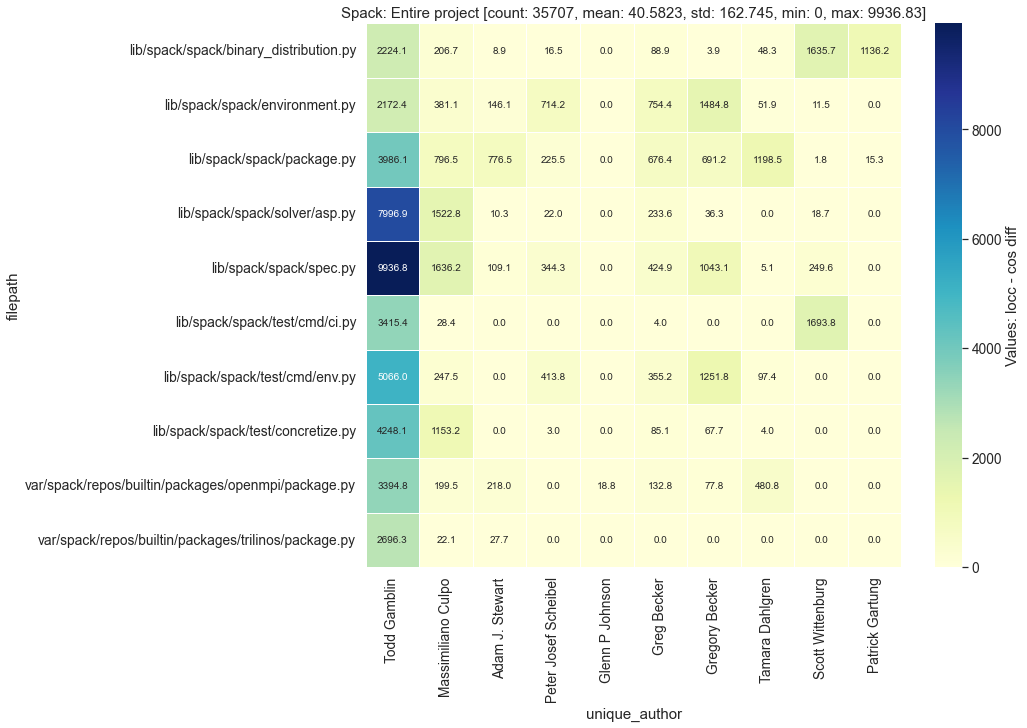

In [24]:
diff_df = file_dev_locc.sub(file_dev_diff, axis=0)
print("Total number of developers: %d" % diff_df.shape[1])
df = vis.commit_data
df['locc - cos diff'] = df['locc']-df['change-size-cos']
d = vis.plot_top_N_heatmap(top_N = 10, locc_metric='locc - cos diff', my_df=df)

We can generate the "hot-files" data for any time period, the way we select it is the same as previously described.

INFO: Creating developer matrix...


unique_author,Adam J. Stewart,Omar Padron,Greg Becker,Sinan81@github,Massimiliano Culpo,Vivek Kale,Todd Gamblin,Peter Josef Scheibel,Marc Mengel,ktsai7
filepath,,,,,,,,,,
lib/spack/spack/environment.py,4,0,134,0,5,0,14,0,0,0
lib/spack/spack/mirror.py,0,0,0,0,0,0,74,4,0,0
lib/spack/spack/relocate.py,0,0,52,0,0,0,0,6,17,0
lib/spack/spack/test/util/util_url.py,0,460,0,0,0,0,0,0,0,0
lib/spack/spack/util/url.py,0,122,0,0,0,0,0,0,0,0


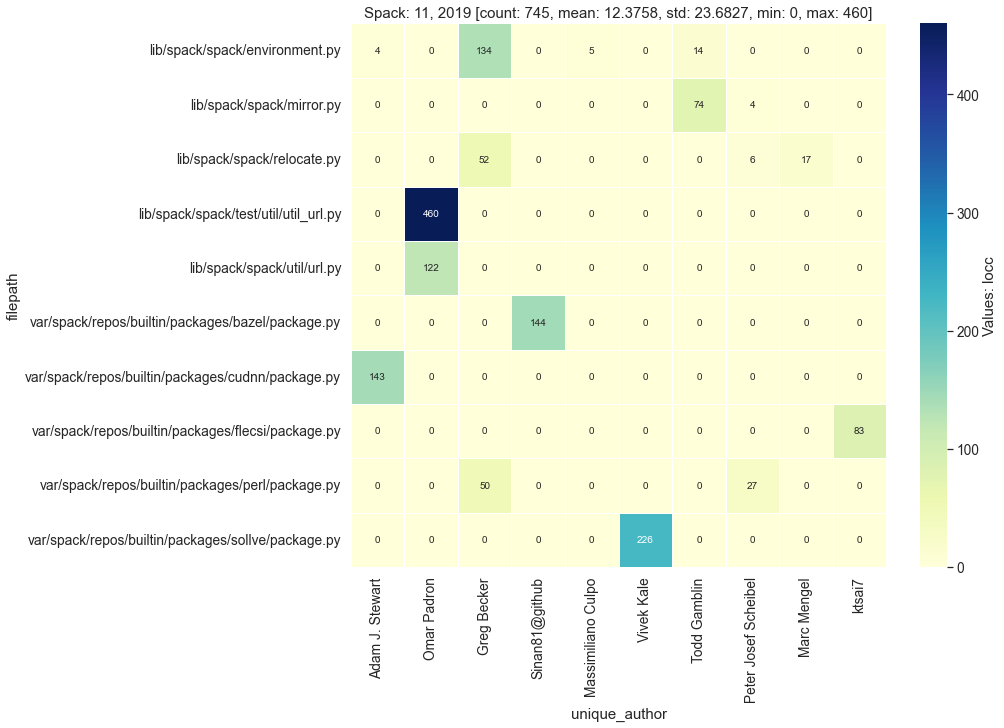

In [25]:
N = 10
vis.set_year(2019)
vis.set_month(11)
vis.set_max_ylabel_length(30)
top_N = vis.plot_top_N_heatmap(N, time_range="month",locc_metric='locc')
top_N.head()

## In the zone
Here we look at what days of the week and times of day developers are most productive. This one also takes the usual argumemts, the defaults are `time_range=None, locc_metric='change-size-cos'`. You can choose between `'sum'` and `'mean'` for aggregating the data over the specified time range (or entire project if time range is None). Using the sum helps see when the bulk of the contributions are made, while `mean` reveals more fine-grained periods of high average productivity better.

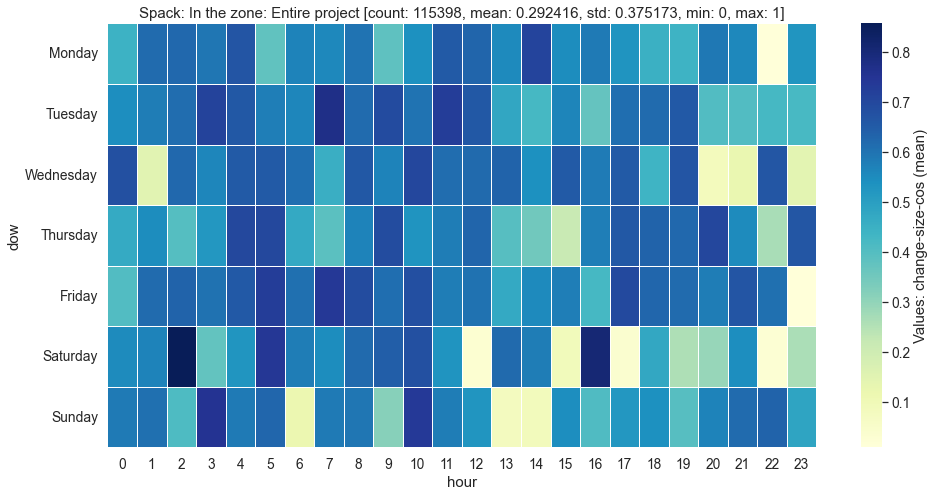

In [26]:
df = vis.plot_zone_heatmap(agg='mean')

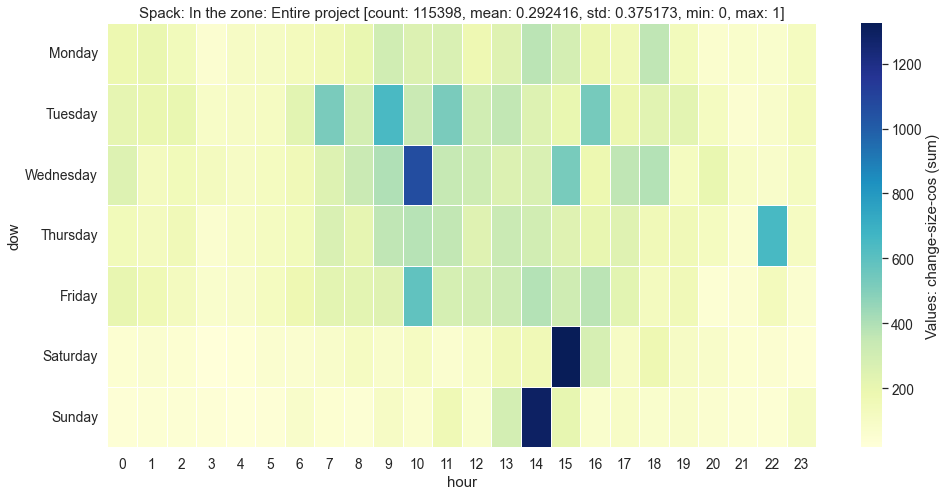

In [27]:
df = vis.plot_zone_heatmap(agg='sum')

## Did anything unusual happen in 2020?
This specific function looks at how 2020 contributions compare with the average (and the previous year).

We use the day-time heatmap again, zooming to specific years, in this case, 2019 and 2020. With `sum`, we see when most of the changes were made, while `mean` reveals when people are most productive.

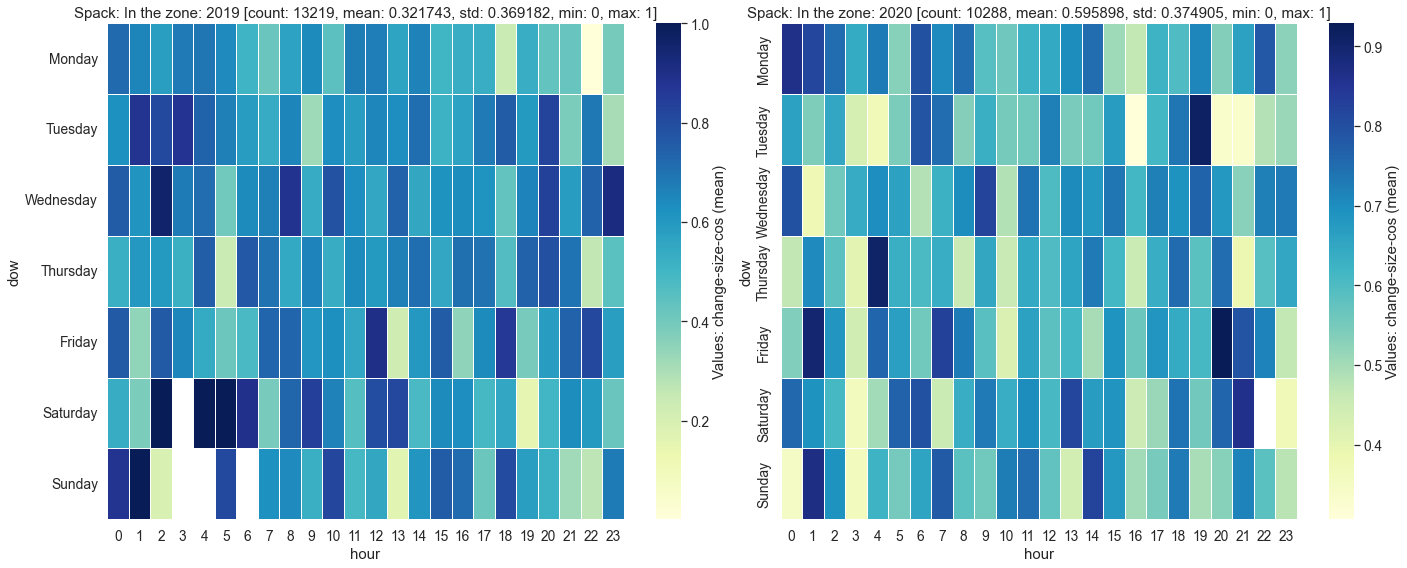

In [28]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
vis.set_year(2019)
df_2019 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[0]),agg='mean')
vis.set_year(2020)
df_2020 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[1]),agg='mean')

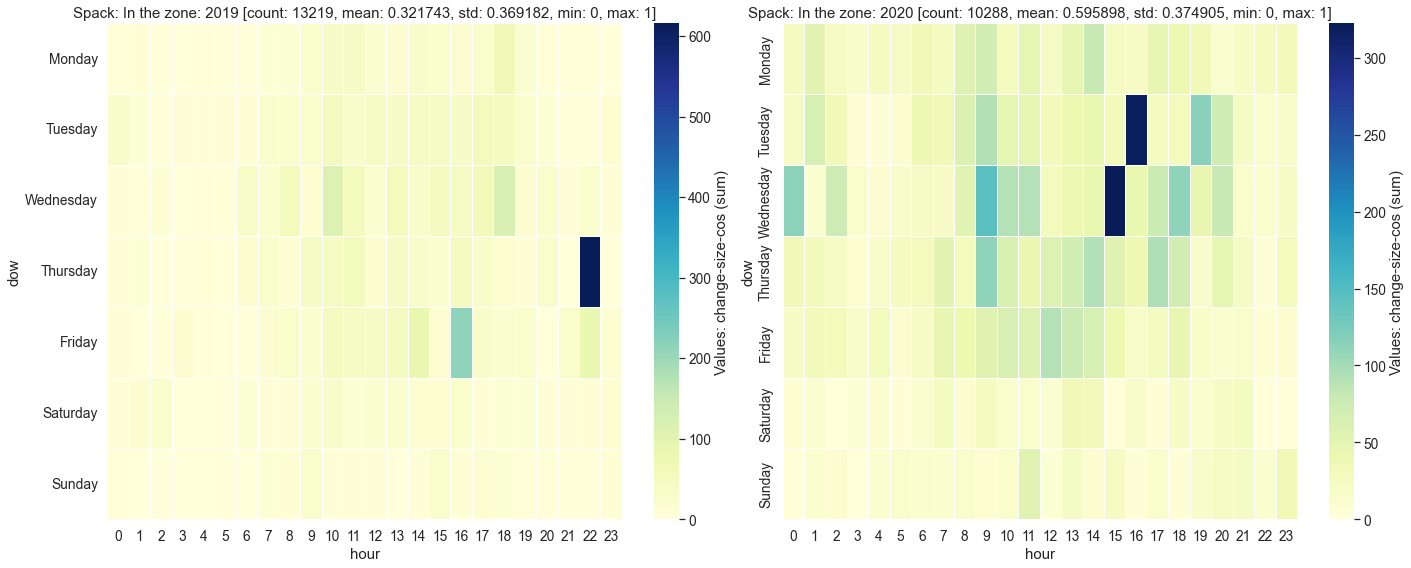

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
vis.set_year(2019)
df_2019 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[0]),agg='sum')
vis.set_year(2020)
df_2020 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[1]),agg='sum')

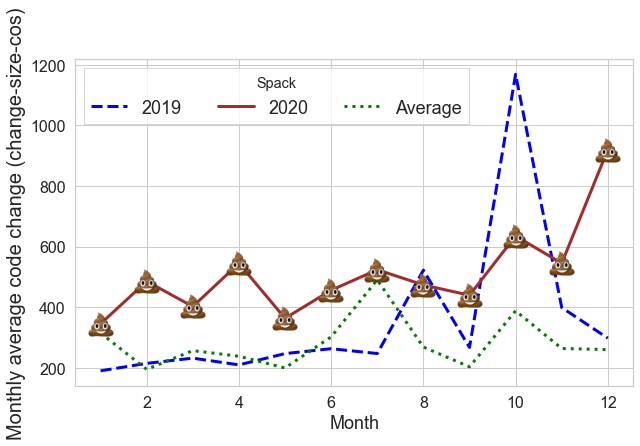

In [30]:
vis.how_was_2020('change-size-cos')

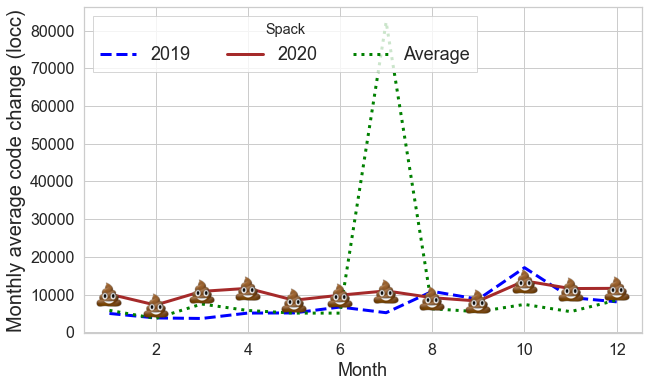

In [31]:
vis.how_was_2020('locc')